<h1><center>Credit Card Fraud Detection</center></h1>

## Problem Statement:

The Credit Card Fraud Detection Problem includes modeling past credit card transactions with the knowledge of the ones that turned out to be fraud. This model is then used to identify whether a new transaction is fraudulent or not. Our aim here is to detect the fraudulent transactions while minimizing the incorrect fraud classifications.

## Data Description

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
!pip install tensorflow

## Loading the Data

The dataset is taken from the [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud) website.

In [3]:
df = pd.read_csv('creditcard.csv')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
74708,55714.0,-1.332696,-0.439609,-1.304924,-4.560938,2.760633,1.996803,-0.015418,1.127049,1.148902,...,0.164043,0.087623,-0.306599,1.035670,0.629465,-1.020216,0.009225,-0.058277,26.31,0
200590,133494.0,-0.116505,-0.316434,-1.605652,-1.735005,-1.560808,0.970015,-0.218502,-3.649816,-0.006121,...,3.485625,0.764858,-1.783412,-0.250199,-0.401144,0.015556,0.921305,0.253827,500.00,0
57533,47948.0,1.319491,-0.828356,0.939690,-0.595160,-1.640584,-0.746815,-1.065167,-0.006806,-0.228938,...,0.385372,0.949107,-0.113054,0.411743,0.378439,-0.048912,0.024781,0.028391,39.99,0
35570,38176.0,1.155050,0.133836,0.519946,1.477599,-0.429482,-0.404029,-0.034290,0.049339,0.491706,...,-0.101763,-0.112743,0.002433,0.380424,0.572811,-0.327295,0.032105,0.014903,1.00,0
253927,156496.0,-0.279765,0.833557,0.821369,0.998447,0.413144,0.176430,0.536826,0.186092,-0.425434,...,-0.094534,-0.309772,0.169788,-0.574061,-0.857689,-0.879394,0.255842,0.237543,63.85,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# Exploratory data analysis

In [7]:
df.shape

(284807, 31)

In [8]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation

In [9]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Handling missing values

In [10]:
df.isnull().values.any()

False

We can see that there is no missing values in any of the columns. Hence, there is no problem with null values in the entire dataset.

### Checking the distribution of the 'Class' column

In [11]:
count_classes = df['Class'].value_counts(sort=True)
count_classes

0    284315
1       492
Name: Class, dtype: int64

In [12]:
Normal = df[df['Class'] == 0 ]
Normal.shape

(284315, 31)

In [13]:
Fraud = df[df['Class'] == 1]
Fraud.shape

(492, 31)

Text(0, 0.5, 'Frequency')

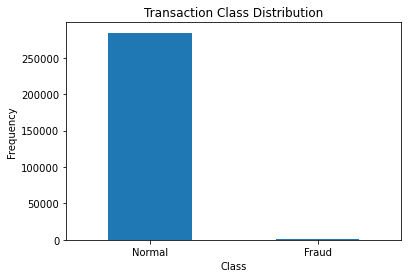

In [14]:
LABELS = ["Normal", "Fraud"]

count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [15]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

We have a highly imbalanced dataset on our hands(Only 0.17% transactions are fraudulent whereas 99.8% transactions are normal). Normal transactions overwhelm the fraudulent ones by a large margin.

Different amount of money used in different transaction classes

In [16]:
Normal['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [17]:
Fraud['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

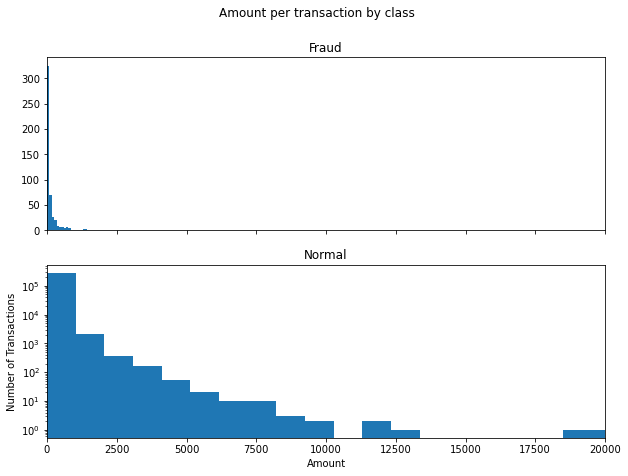

In [18]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,7), sharex=True)
f.suptitle('Amount per transaction by class')


ax1.hist(Fraud['Amount'], bins = 25)
ax1.set_title('Fraud')

ax2.hist(Normal['Amount'], bins = 25)
ax2.set_title('Normal')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')

plt.show()

We can see that the fraudulent transctions are mostly densed in the lower range of amount, whereas the non-fraudulent transctions are spreaded throughout low to high range of amount.

Let's check if there is any specific pattern for the fraudulent and non-fraudulent transctions with respect to Time.

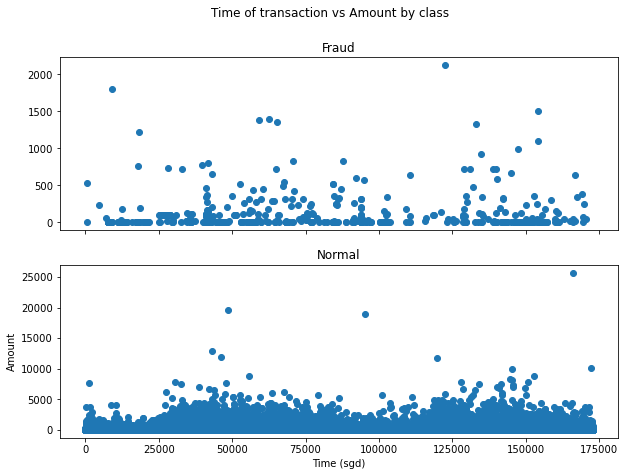

In [19]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,7), sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(Fraud['Time'], Fraud['Amount'])
ax1.set_title('Fraud')

ax2.scatter(Normal['Time'], Normal['Amount'])
ax2.set_title('Normal')

plt.xlabel('Time (sgd)')
plt.ylabel('Amount')
plt.show()

It does not seem like the time of transaction really matters. Hence, we can drop the Time column.

In [20]:
# Dropping the Time column
df.drop('Time', axis=1, inplace=True)

In [21]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Feature correlation heatmap

Plotting a heatmap to gain a high level view of relationships amongst the features.

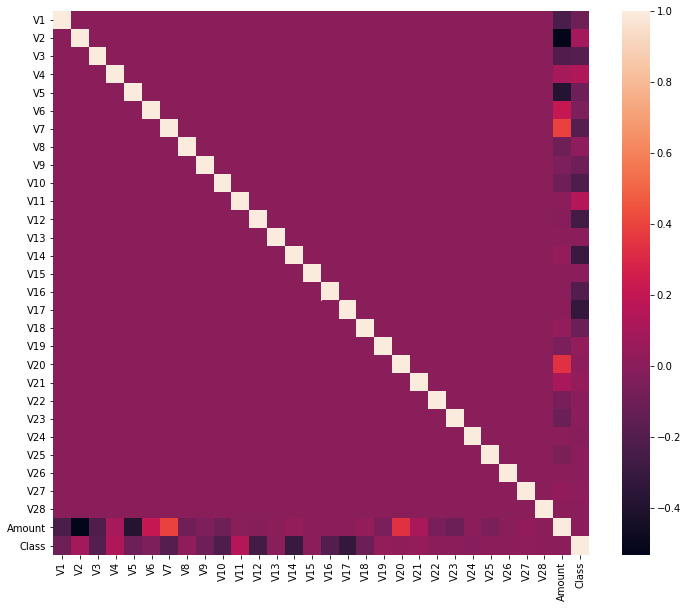

In [22]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr())
plt.show();

The correlation matrix shows that none of the V1 trough V28 PCA components have any correlation to each other however if we observe Class has some form positive and negative correlations with the V components but has no correlation with the Amount.

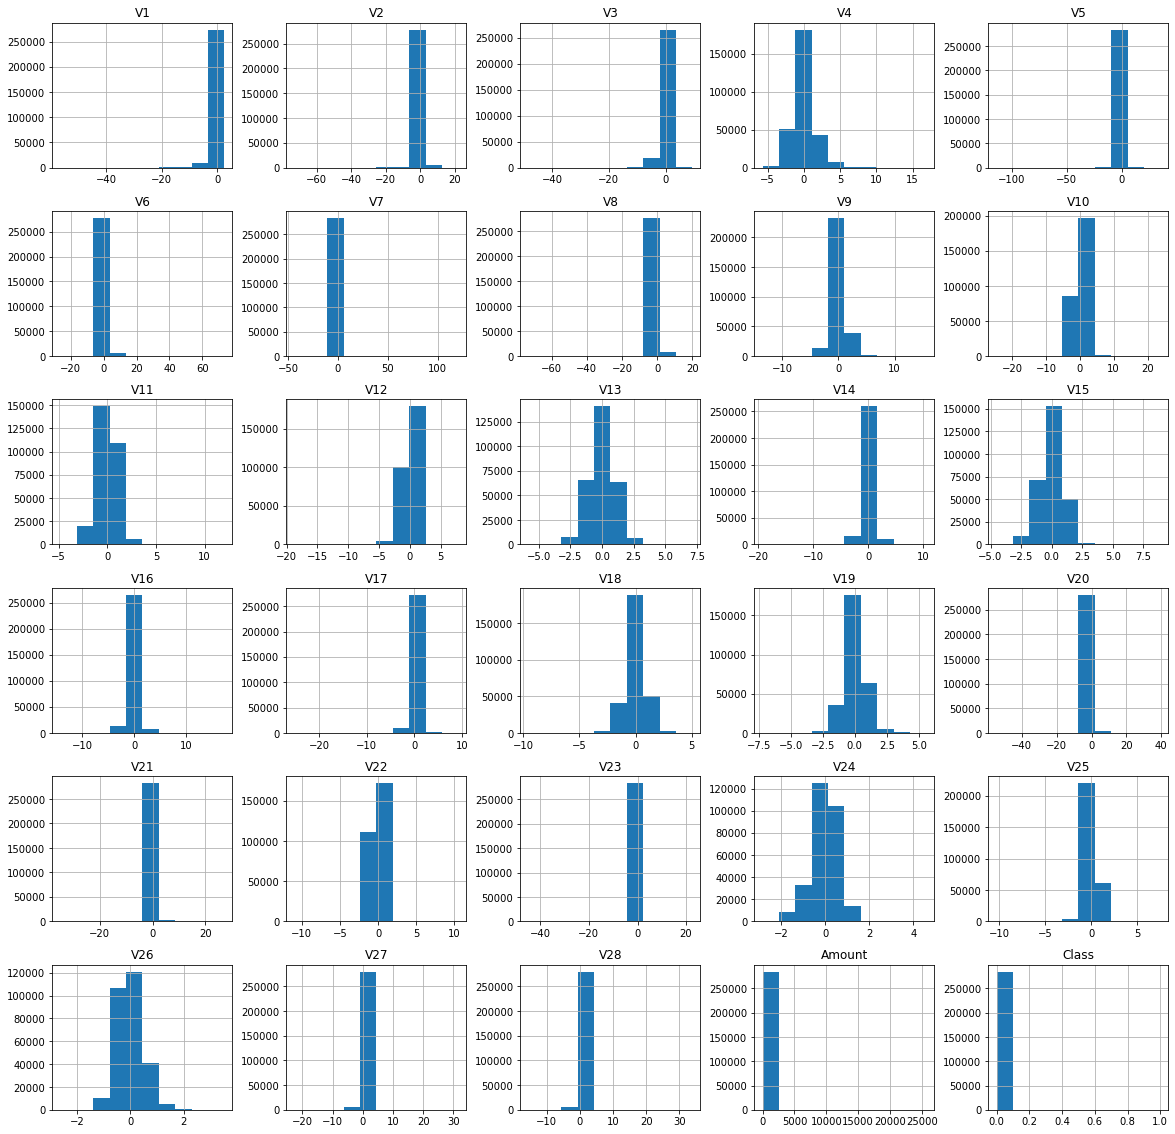

In [23]:
df.hist(figsize=(20, 20));

# Data Pre-processing

## Feature Scaling

We need to scale only the Amount column as all other columns are already scaled by the PCA transformation. I'll
use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [24]:
# Standardization method
from sklearn.preprocessing import StandardScaler

# Instantiate the Scaler
scaler = StandardScaler()

#Fit the data into scaler and transform
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

In [25]:
df['Amount'].head(15)

0     0.244964
1    -0.342475
2     1.160686
3     0.140534
4    -0.073403
5    -0.338556
6    -0.333279
7    -0.190107
8     0.019392
9    -0.338516
10   -0.322044
11   -0.313289
12    0.132538
13   -0.243282
14   -0.118142
Name: Amount, dtype: float64

In [26]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [27]:
from sklearn.model_selection import train_test_split

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
X_train.shape

(199364, 29)

In [29]:
X_test.shape

(85443, 29)

## Undersampling

We've seen in total dataset we have only 492 fraudlent records, which makes our dataset imbalanced or biased. 99% records are real transaction. Only 1% is fraud. So our data is not balanced. It may result in a model which is biased toward real transaction scenario. So we will apply undersampling and oversampling technique to overcome this conition.

In [30]:
!pip install imblearn

In [31]:
# Undersample 0-class(Normal) and concat the DataFrames of both class
Normal = Normal.sample(Fraud.shape[0])

data = pd.concat([Normal, Fraud], axis=0)

In [32]:
data.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
263706,161075.0,0.366445,-3.729878,-2.101705,-1.445950,-1.486707,-0.315907,0.521557,-0.281985,2.589277,...,0.749550,0.351855,-0.724481,0.329954,-0.249825,-0.840739,-0.098602,0.121040,908.12,0
51746,45101.0,-1.302968,0.961806,1.659462,1.684610,-1.031081,0.887102,-0.931354,1.359263,0.140334,...,-0.151095,-0.322697,0.061856,0.206513,-0.455787,-0.473218,-0.131075,-0.017701,4.99,0
138380,82625.0,-0.384157,1.182202,1.294385,-0.000532,0.336432,-0.480029,0.730261,-0.013463,-0.608430,...,-0.219913,-0.461550,-0.000622,0.060601,-0.186466,0.096918,0.270982,0.097889,3.78,0
8476,11357.0,1.205947,-0.097997,0.778743,0.329650,-0.746506,-0.512260,-0.387660,-0.080471,1.791679,...,-0.200207,-0.118866,-0.035198,0.575839,0.362645,1.043194,-0.097206,-0.014546,6.60,0
212464,138868.0,-0.641122,1.278560,-0.430881,-1.668430,2.467950,-0.436300,2.351427,-0.642997,-1.022655,...,0.249246,0.963935,-1.114873,-1.348081,1.918238,-0.130633,-0.335049,-0.231927,6.75,0
225241,144164.0,1.972631,-0.376904,-0.039935,0.350005,-0.654750,-0.034050,-0.806541,0.056032,1.384589,...,0.082754,0.448792,0.284060,0.751828,-0.324747,-0.446744,0.060493,-0.016537,8.34,0
128049,78581.0,1.145562,0.284826,0.693262,1.161118,-0.467421,-0.644477,-0.000834,-0.004609,-0.239434,...,-0.255042,-0.838982,0.176552,0.471924,0.201158,-0.742954,0.016863,0.025036,13.23,0
58546,48440.0,-1.739612,-0.932462,0.503179,-1.739317,-0.361534,-1.444493,0.617619,0.163205,-1.452205,...,-0.101616,-0.563512,0.335833,0.403417,-0.026824,0.706801,-0.160399,-0.079400,194.99,0
38406,39383.0,1.258984,-0.397141,-0.138262,-1.033853,-0.236713,-0.085368,-0.206219,0.060717,1.448772,...,-0.257144,-0.574863,-0.187993,-0.848822,0.732816,-0.744853,0.050683,0.005869,29.90,0
270268,163995.0,2.144634,-0.628362,-1.795720,-0.658261,0.058194,-0.411478,-0.179937,-0.118751,-0.675822,...,-0.486673,-1.029032,0.258964,0.092325,-0.102429,-0.509526,-0.024916,-0.056932,27.50,0


In [33]:
# Dropping the Time column
data.drop('Time', axis=1, inplace=True)

In [34]:
data.tail(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
274382,-5.766879,-8.402154,0.056543,6.950983,9.880564,-5.773192,-5.748879,0.721743,-1.076274,2.688670,...,0.880395,-0.130436,2.241471,0.665346,-1.890041,-0.120803,0.073269,0.583799,0.00,1
274475,-0.956390,2.361594,-3.171195,1.970759,0.474761,-1.902598,-0.055178,0.277831,-1.745854,-2.516628,...,0.473211,0.719400,0.122458,-0.255650,-0.619259,-0.484280,0.683535,0.443299,39.90,1
275992,-2.027135,-1.131890,-1.135194,1.086963,-0.010547,0.423797,3.790880,-1.155595,-0.063434,1.334414,...,-0.315105,0.575520,0.490842,0.756502,-0.142685,-0.602777,0.508712,-0.091646,634.30,1
276071,2.091900,-0.757459,-1.192258,-0.755458,-0.620324,-0.322077,-1.082511,0.117200,-0.140927,0.249311,...,0.288253,0.831939,0.142007,0.592615,-0.196143,-0.136676,0.020182,-0.015470,19.95,1
276864,-1.374424,2.793185,-4.346572,2.400731,-1.688433,0.111136,-0.922038,-2.149930,-2.027474,-4.390842,...,-0.870779,0.504849,0.137994,0.368275,0.103137,-0.414209,0.454982,0.096711,349.08,1
279863,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,-5.587794,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,-5.245984,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1
281674,1.991976,0.158476,-2.583441,0.408670,1.151147,-0.096695,0.223050,-0.068384,0.577829,-0.888722,...,-0.164350,-0.295135,-0.072173,-0.450261,0.313267,-0.289617,0.002988,-0.015309,42.53,1


In [35]:
new_counts =data['Class'].value_counts()

print('Random under-sampling:')
new_counts

Random under-sampling:


1    492
0    492
Name: Class, dtype: int64

Text(0.5, 0, 'Class (0:Normal, 1:Fraudulent)')

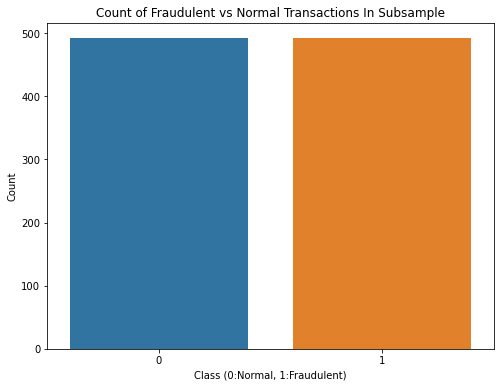

In [36]:
plt.figure(figsize=(8,6))

sns.barplot(x = new_counts.index, y = new_counts)
plt.title('Count of Fraudulent vs Normal Transactions In Subsample')
plt.ylabel('Count')
plt.xlabel('Class (0:Normal, 1:Fraudulent)')

In [37]:
X = data.drop(['Class'], axis=1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
# Number of classes in training Data
y_train.value_counts()

1    346
0    342
Name: Class, dtype: int64

In [39]:
X_train.shape, X_test.shape

((688, 29), (296, 29))

#  Models Building

## 1. Artificial Neural Network (ANN)

The ANN takes a vector of length 29 as input. This represents the information related to each transactions, for instance, each line with 29 columns from the dataset. 
For each transaction, the final layer will output a probability distribution (sigmoid activation function) and classify either as **normal (0)** or **fraudulent (1)**.


In [40]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 30)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=10,
                                            max_value=500,
                                            step=10),
                               activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss = 'binary_crossentropy',
        metrics=['accuracy'])
    return model

<ipython-input-40-fefcfaea000d>:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [41]:
!pip install keras-tuner --upgrade

Requirement already up-to-date: keras-tuner in /Applications/anaconda3/lib/python3.8/site-packages (1.1.0)


In [42]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=3,
    directory='project',
    project_name='Credit_Card')

In [43]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 30, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 500, 'step': 10, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 500, 'step': 10, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [44]:
tuner.search(X_train, y_train,
             epochs=100,
             validation_data=(X_test, y_test))

Trial 15 Complete [00h 01m 51s]
val_accuracy: 0.9234234293301901

Best val_accuracy So Far: 0.9380630652109782
Total elapsed time: 00h 37m 57s
INFO:tensorflow:Oracle triggered exit


## 2. Logistic Regression

In [45]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


# Logistic Regression parameters for K-fold cross vaidation
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}
folds = KFold(n_splits=5, shuffle=True, random_state=4)


#perform cross validation
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        n_jobs = -1,
                        verbose = 1,
                        return_train_score=True) 

#perform hyperparameter tuning
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [46]:
#print the evaluation result by choosing a evaluation metric
print('Best ROC AUC score: ', model_cv.best_score_)

#print the optimum value of hyperparameters
print('Best hyperparameters: ', model_cv.best_params_)

Best ROC AUC score:  0.9844157096769628
Best hyperparameters:  {'C': 0.01}


In [47]:
# cross validation results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.106038,0.015002,0.009571,0.003558,0.01,{'C': 0.01},0.997255,0.972926,0.981208,0.981360,...,0.984416,0.008254,1,0.984704,0.990468,0.988137,0.988089,0.986390,0.987558,0.001928
1,0.071468,0.008118,0.005952,0.000290,0.1,{'C': 0.1},0.996622,0.973143,0.975084,0.977632,...,0.982234,0.008985,2,0.986199,0.992350,0.989817,0.989896,0.989065,0.989465,0.001973
2,0.085877,0.004634,0.006147,0.000724,1,{'C': 1},0.995566,0.974659,0.964738,0.974123,...,0.978659,0.010459,3,0.986676,0.992814,0.990782,0.991307,0.990461,0.990408,0.002033
3,0.086269,0.018303,0.006930,0.000673,10,{'C': 10},0.986909,0.972710,0.953336,0.973026,...,0.974080,0.011873,6,0.987695,0.993186,0.991668,0.990687,0.991054,0.990858,0.001797
4,0.071629,0.008889,0.006115,0.000452,100,{'C': 100},0.995144,0.972060,0.956292,0.971491,...,0.975839,0.013099,5,0.987443,0.992867,0.991576,0.990991,0.991225,0.990820,0.001809
5,0.077384,0.014573,0.006442,0.000265,1000,{'C': 1000},0.993032,0.973359,0.956926,0.973246,...,0.976197,0.012159,4,0.988039,0.993040,0.991245,0.990397,0.990883,0.990721,0.001611


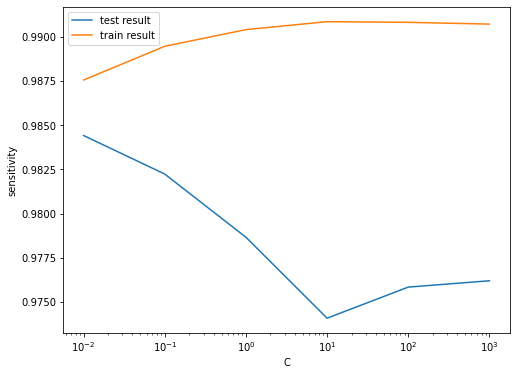

In [48]:
# plot of C versus train and validation scores
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('sensitivity')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

### Logistic Regression with optimal C

In [49]:
# Instantiating the model with best C
log_reg = LogisticRegression(C=0.01)

# Fitting the model on train dataset
log_reg.fit(X_train, y_train)

LogisticRegression(C=0.01)

### Prediction and model evalution on the train set

In [50]:
# Creating function to display ROC-AUC score, f1 score and classification report
def display_scores(y_test, y_pred):
    '''
    Display ROC-AUC score, f1 score and classification report of a model.
    '''
    print(f"F1 Score: {round(f1_score(y_test, y_pred)*100,2)}%") 
    print(f"Classification Report: \n {classification_report(y_test, y_pred)}")

In [51]:
# Predictions on the train set
y_train_pred = log_reg.predict(X_train)

In [52]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score, classification_report

display_scores(y_train, y_train_pred)

F1 Score: 94.14%
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.98      0.95       342
           1       0.98      0.90      0.94       346

    accuracy                           0.94       688
   macro avg       0.95      0.94      0.94       688
weighted avg       0.95      0.94      0.94       688



In [53]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# predict probabilities
y_pred_prob = model_cv.predict_proba(X_train)
# keep probabilities for the positive outcome only
y_pred_prob = y_pred_prob[:, 1]

In [54]:
#from numpy import argmax

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
# get the best threshold
# J = tpr - fpr
# ix = argmax(J)
# best_thresh = thresholds[ix]
# print('Best Threshold=%f' % (best_thresh))

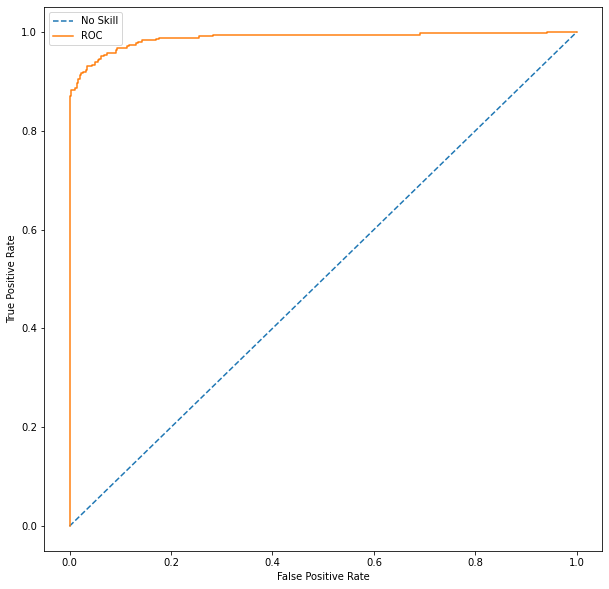

In [55]:
from sklearn import metrics

# plot the roc curve for the model
plt.figure(figsize = (10,10))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='ROC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

### Evaluating the model on the test set

In [56]:
# Making prediction on the test set
y_test_pred = log_reg.predict(X_test)
display_scores(y_test, y_test_pred)

F1 Score: 93.19%
Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       150
           1       0.98      0.89      0.93       146

    accuracy                           0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.94      0.94      0.94       296



In [57]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

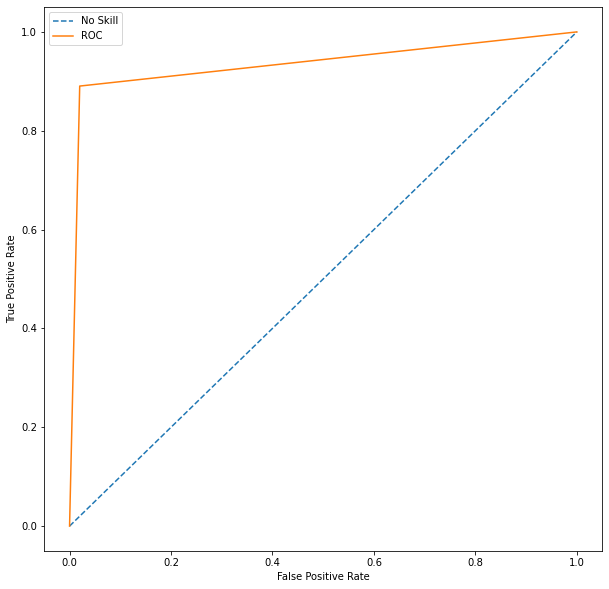

In [58]:
# plot the roc curve for the model
plt.figure(figsize = (10,10))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='ROC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [59]:
from sklearn.metrics import confusion_matrix

#Confusion matrix:
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
                                    
Accuracy_LR = metrics.accuracy_score(y_test, y_test_pred)
print(Accuracy_LR)

[[147   3]
 [ 16 130]]
0.9358108108108109


<AxesSubplot:>

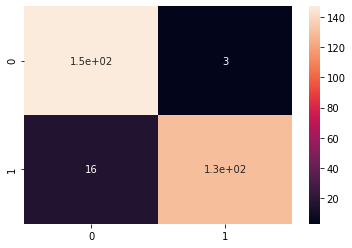

In [60]:
sns.heatmap(cm, annot=True)

## 3. Decision Tree

In [61]:
from sklearn.tree import DecisionTreeClassifier 

# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
dtree = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'roc_auc',
                           cv = 3, 
                           n_jobs=-1,
                           verbose = 1)



In [62]:
#fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='roc_auc', verbose=1)

In [63]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010551,0.000876,0.006605,0.001945,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.977352,0.962166,0.964150,0.967889,0.006740,1
1,0.009029,0.001430,0.007370,0.003786,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.971983,0.962243,0.961823,0.965349,0.004694,4
2,0.009659,0.003896,0.008025,0.002105,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.955006,0.949809,0.959687,0.954834,0.004034,6
3,0.009748,0.001131,0.005069,0.000378,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.951338,0.950267,0.960641,0.954082,0.004658,7
4,0.009491,0.000345,0.007045,0.000892,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.971642,0.962166,0.964035,0.965948,0.004098,2
5,0.010957,0.001899,0.007862,0.002335,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.972134,0.962090,0.962777,0.965667,0.004582,3
6,0.008214,0.000291,0.009983,0.005413,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.951338,0.951182,0.959687,0.954069,0.003973,8
7,0.012803,0.003696,0.009109,0.005422,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.955460,0.950420,0.961594,0.955825,0.004569,5


In [64]:
# Printing the optimal score and hyperparameters
print("Best roc auc score : ", grid_search.best_score_)
print(grid_search.best_estimator_)

Best roc auc score :  0.9678891913692277
DecisionTreeClassifier(max_depth=5, min_samples_leaf=50, min_samples_split=50)


### Decision Tree with optimal hyperparameters

In [65]:
# Model with optimal hyperparameters
opt_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)

opt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50,
                       random_state=100)

### Prediction on the train set

In [66]:
y_train_pred = opt_model.predict(X_train)
display_scores(y_train, y_train_pred)

F1 Score: 92.4%
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.98      0.93       342
           1       0.97      0.88      0.92       346

    accuracy                           0.93       688
   macro avg       0.93      0.93      0.93       688
weighted avg       0.93      0.93      0.93       688



In [67]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)

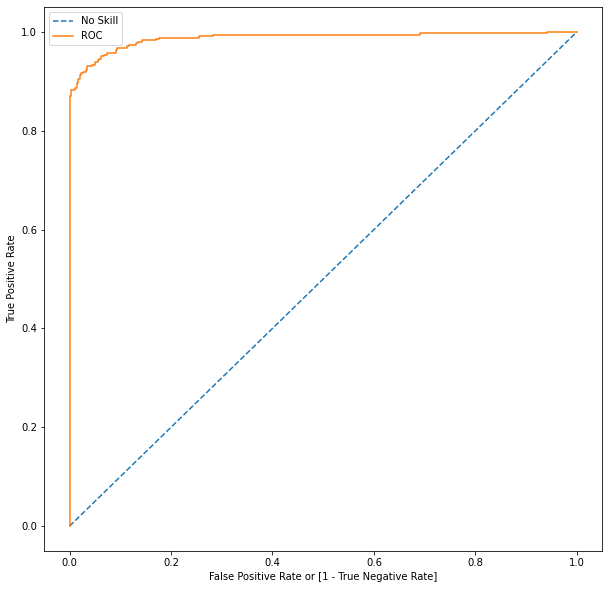

In [68]:
# plot the roc curve for the model
plt.figure(figsize = (10,10))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='ROC')
# axis labels
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

### Evaluating the model on the test set

In [69]:
y_test_pred = opt_model.predict(X_test)
display_scores(y_test, y_test_pred)

F1 Score: 90.91%
Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       150
           1       0.97      0.86      0.91       146

    accuracy                           0.92       296
   macro avg       0.92      0.91      0.92       296
weighted avg       0.92      0.92      0.92       296



In [70]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

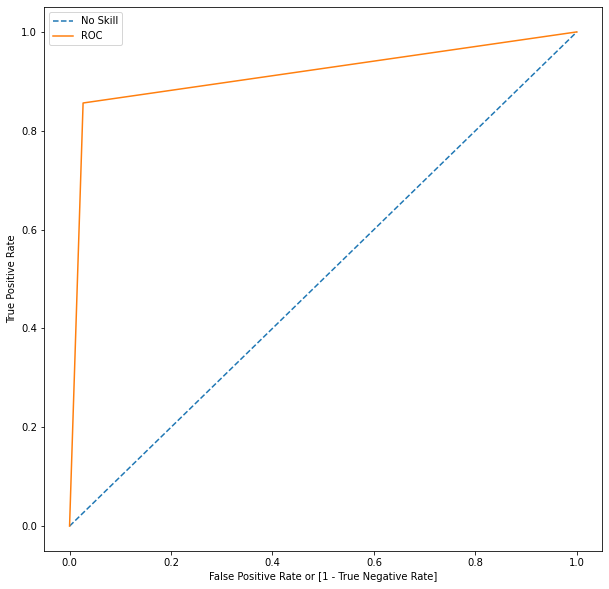

In [71]:
# plot the roc curve for the model
plt.figure(figsize = (10,10))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='ROC')
# axis labels
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [72]:
#Confusion matrix:

cm = confusion_matrix(y_test, y_test_pred)
print(cm)

Accuracy_DT = metrics.accuracy_score(y_test,y_test_pred)
print(Accuracy_DT)

[[146   4]
 [ 21 125]]
0.9155405405405406


<AxesSubplot:>

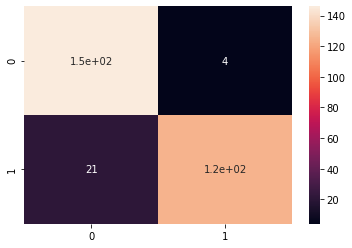

In [73]:
sns.heatmap(cm, annot=True)

## 4. Random Forest

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV,GridSearchCV,StratifiedKFold

#Pipeline Processing for powertranformation and Decision Tree classifier
pipe = Pipeline([('pt',PowerTransformer()), ('rf', RandomForestClassifier(random_state=42))])

# hyperparameter space
params = {"rf__criterion": ['gini', 'entropy'],"rf__n_estimators": [100,120],
         "rf__min_samples_leaf": [5,10]}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
rf_grid = RandomizedSearchCV(estimator=pipe, cv=folds, param_distributions=params, scoring='roc_auc', n_jobs=-1, verbose=1,
                             random_state=42 )

In [75]:
#fit the grid search to the data
rf_grid.fit(X_train,y_train)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
                   estimator=Pipeline(steps=[('pt', PowerTransformer()),
                                             ('rf',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'rf__criterion': ['gini', 'entropy'],
                                        'rf__min_samples_leaf': [5, 10],
                                        'rf__n_estimators': [100, 120]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [76]:
# We automatically get the logistic regression with the best parameters.
rf_grid.best_estimator_

Pipeline(steps=[('pt', PowerTransformer()),
                ('rf',
                 RandomForestClassifier(criterion='entropy',
                                        min_samples_leaf=10, n_estimators=120,
                                        random_state=42))])

In [77]:
# print best hyperparameters
print("Best Recall: ", rf_grid.best_score_)
print("Best hyperparameters: ", rf_grid.best_params_)

Best Recall:  0.9809218633893382
Best hyperparameters:  {'rf__n_estimators': 120, 'rf__min_samples_leaf': 10, 'rf__criterion': 'entropy'}


### Random Forest with optimal hyperparameters

In [78]:
# Model with optimal hyperparameters

params = {'rf__n_estimators' : [100], 'rf__min_samples_leaf' : [10], 'rf__criterion' : ['entropy']}

opt_model = RandomizedSearchCV(estimator=pipe, cv=folds, param_distributions=params, scoring='roc_auc', n_jobs=-1, verbose=1,
                             random_state=42 )

opt_model.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
                   estimator=Pipeline(steps=[('pt', PowerTransformer()),
                                             ('rf',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'rf__criterion': ['entropy'],
                                        'rf__min_samples_leaf': [10],
                                        'rf__n_estimators': [100]},
                   random_state=42, scoring='roc_auc', verbose=1)

### Prediction on the train set

In [79]:
y_train_pred = opt_model.predict(X_train)
display_scores(y_train, y_train_pred)

F1 Score: 95.2%
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.99      0.95       342
           1       0.99      0.92      0.95       346

    accuracy                           0.95       688
   macro avg       0.96      0.95      0.95       688
weighted avg       0.96      0.95      0.95       688



In [80]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)

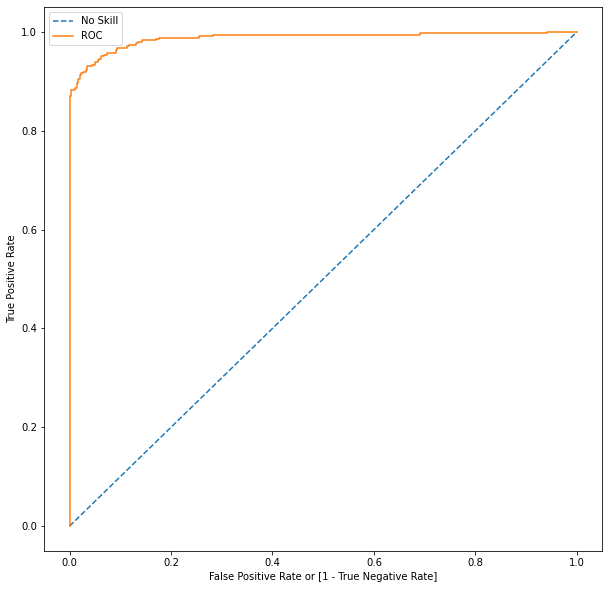

In [81]:
# plot the roc curve for the model
plt.figure(figsize = (10,10))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='ROC')
# axis labels
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

### Evaluating the model on the test set

In [82]:
y_test_pred = opt_model.predict(X_test)
display_scores(y_test, y_test_pred)

F1 Score: 93.48%
Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.99      0.94       150
           1       0.99      0.88      0.93       146

    accuracy                           0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.94      0.94      0.94       296



In [83]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

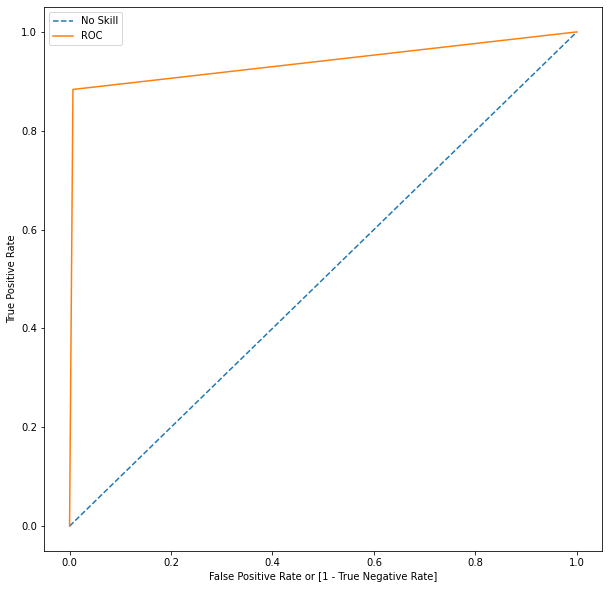

In [84]:
# plot the roc curve for the model
plt.figure(figsize = (10,10))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='ROC')
# axis labels
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [85]:
#Confusion matrix:

cm = confusion_matrix(y_test, y_test_pred)
print(cm)

Accuracy_RF = metrics.accuracy_score(y_test, y_test_pred)
print(Accuracy_RF)

[[149   1]
 [ 17 129]]
0.9391891891891891


<AxesSubplot:>

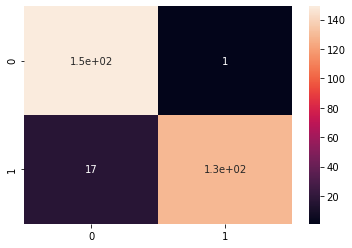

In [86]:
sns.heatmap(cm, annot=True)

## 5. XGBoost 

In [87]:
from xgboost import XGBClassifier

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)



In [88]:
# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)  

In [89]:
# fit the model
model_cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[16:36:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:114

[16:36:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [90]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.173285,0.010539,0.005054,0.000183,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.980868,0.970175,0.975133,0.975392,0.004369,5,1.0,0.999981,0.999734,0.999905,0.000121
1,0.200989,0.020045,0.006881,0.002446,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.983288,0.971854,0.975439,0.976860,0.004775,1,1.0,1.000000,1.000000,1.000000,0.000000
2,0.215299,0.007297,0.005953,0.000798,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.981397,0.969031,0.979024,0.976484,0.005358,2,1.0,1.000000,1.000000,1.000000,0.000000
3,0.169583,0.022204,0.004902,0.000189,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.979280,0.964531,0.963082,0.968964,0.007318,6,1.0,0.999981,0.999734,0.999905,0.000121
4,0.169443,0.033711,0.005569,0.000705,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.980112,0.972006,0.975820,0.975979,0.003311,3,1.0,1.000000,1.000000,1.000000,0.000000
5,0.146417,0.013658,0.005007,0.000338,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.983439,0.964073,0.978947,0.975487,0.008276,4,1.0,1.000000,1.000000,1.000000,0.000000


In [91]:
# Printing best params
model_cv.best_params_

{'learning_rate': 0.2, 'subsample': 0.6}

### XGBoost model with optimal hyperparameter

In [92]:
# Printing best params
params = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.9,
          'objective':'binary:logistic'}

# fit model on training data
xgb_opt = XGBClassifier(params = params)
xgb_opt.fit(X_train, y_train)

/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:36:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.9},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

### Prediction and model evalution on the train set

In [93]:
# Predictions on the train set
y_train_pred = xgb_opt.predict(X_train)

display_scores(y_train, y_train_pred)

F1 Score: 100.0%
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       342
           1       1.00      1.00      1.00       346

    accuracy                           1.00       688
   macro avg       1.00      1.00      1.00       688
weighted avg       1.00      1.00      1.00       688



In [94]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)

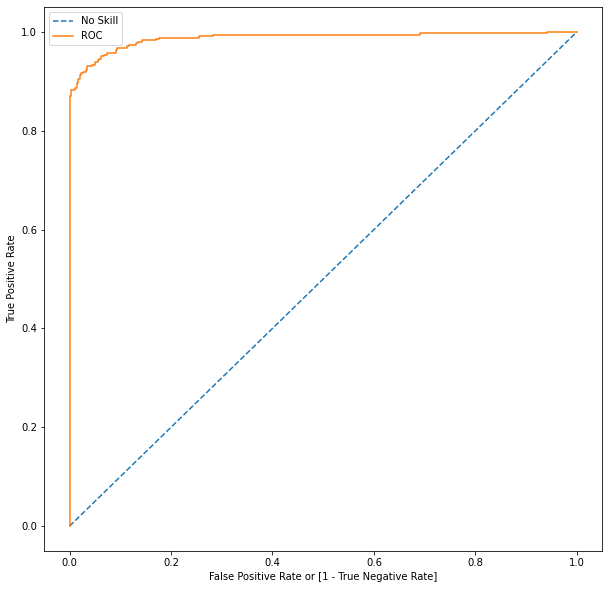

In [95]:
# plot the roc curve for the model
plt.figure(figsize = (10,10))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='ROC')
# axis labels
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

### Evaluating the model on the test set

In [96]:
# Predictions on the test set
y_test_pred = xgb_opt.predict(X_test)
display_scores(y_test, y_test_pred)

F1 Score: 94.29%
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.99      0.95       150
           1       0.99      0.90      0.94       146

    accuracy                           0.95       296
   macro avg       0.95      0.95      0.95       296
weighted avg       0.95      0.95      0.95       296



In [97]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

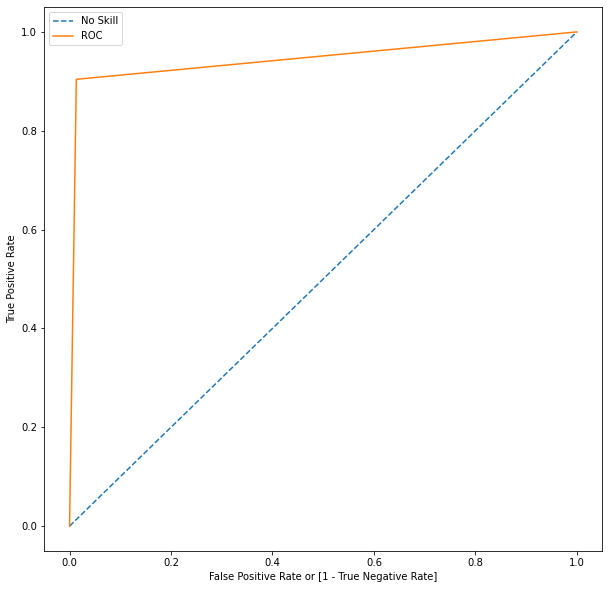

In [98]:
# plot the roc curve for the model
plt.figure(figsize = (10,10))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='ROC')
# axis labels
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [99]:
#Confusion matrix:

cm = confusion_matrix(y_test, y_test_pred)
print(cm)

Accuracy_XGB = metrics.accuracy_score(y_test,y_test_pred)
print(Accuracy_XGB)

[[148   2]
 [ 14 132]]
0.9459459459459459


<AxesSubplot:>

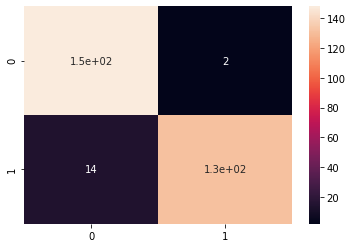

In [100]:
sns.heatmap(cm, annot=True)

In [102]:
Accuracy_ANN = 0.9380630652109782

labels = ['Artificial Neural Network', 'Logistic Regression','Decision Tree','Random Forest','XGBoost']

Accuracy_score = [Accuracy_ANN, Accuracy_LR, Accuracy_DT, Accuracy_RF, Accuracy_XGB]

score_tab_acc = pd.DataFrame(list(zip(labels, Accuracy_score)), 
               columns =['Algorithm', 'Model accuracy score']) 


score_tab_acc


,Algorithm,Model accuracy score
0,Artificial Neural Network,0.938063
1,Logistic Regression,0.935811
2,Decision Tree,0.915541
3,Random Forest,0.939189
4,XGBoost,0.945946


# Conclusion

We have tried several models till now. We have noticed that most of the models have performed more or less well in terms of ROC score, Recall and Precision.

While picking the best model we should consider few things such as whether we have required infrastructure, resources or computational power to run the model or not. For the models such as **Artificial Neural Network (ANN)**, **Random Forest** and **XGBoost** we require heavy computational resources and eventually to build that infrastructure the cost of deploying the model increases. On the other hand the simpler model such as **Logistic Regression** requires less computational resources, so the cost of building the model is less.

We also have to consider that for little change of the ROC score how much monetary loss of gain the bank incur. If the amount if huge then we have to consider building the complex model even though the cost of building the model is high

For banks with smaller average transaction value, we would want high precision because we only want to label relevant transactions as fraudulent. For every transaction that is flagged as fraudulent, we can add the human element to verify whether the transaction was done by calling the customer. However, when precision is low, such tasks are a burden because the human element has to be increased.

For banks having a larger transaction value, if the recall is low, i.e., it is unable to detect transactions that are labelled as non-fraudulent. So we have to consider the losses if the missed transaction was a high-value fraudulent one.

So here, to save the banks from high-value fraudulent transactions, we have to focus on a high recall in order to detect actual fraudulent transactions.

After performing several models, we have seen that in the balanced dataset with Undersample technique the **XGBoost** model has good ROC score and also high Recall. Hence, we can go with the **XGBoost** model here. It is also easier to interpret and explain to the business.